<h1>Содержание<span class="tocSkip"></span></h1>
<br>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#1-Подготовка-окружения">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>
                    Подготовка окружения
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#2-Загрузка-данных">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>
                    Загрузка данных
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#3-Simple-RNN">
                    <span class="toc-item-num">3&nbsp;&nbsp;</span>
                    Simple RNN
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#4-Общий-вывод">
                    <span class="toc-item-num">4&nbsp;&nbsp;</span>
                    Общий вывод
                </a>
            </span>
        </li>
    </ul>
</div>

# Генеративные текстовые нейросети | Simple RNN

**Постановка задачи:** натренировать и сравнить качество нескольких генеративных текстовых моделей на одном из заданных текстовых датасетов.

**Источник данных:** [Harry Potter and the Methods of Rationality](https://hpmor.ru/).

**Характер данных:** текст книги "Гарри Поттер и методы рационального мышления".

**Основные этапы:** исследовать следующие нейросетевые архитектуры:

1. Simple RNN с посимвольной и пословной токенизацией.
2. Однонаправленная однослойная и многослойная LSTM c посимвольной токенизацией и токенизацией по словам и [на основе BPE](https://keras.io/api/keras_nlp/tokenizers/byte_pair_tokenizer/).
3. Двунаправленная LSTM.
4. *(На хорошую оценку)* трансформерная архитектура (GPT) "с нуля" [пример](https://keras.io/examples/generative/text_generation_gpt/).
5. *(На отличную оценку)* дообучение предобученной GPT-сети [пример](https://github.com/ZotovaElena/RuGPT3_finetuning).

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

# Реализации

1. Simple RNN (текущий файл)
2. [Однонаправленная LSTM + BPE](https://github.com/MAILabs-Edu-2023/magai_lab3_gennn-nlp_lab/blob/main/unidirectional_LSTM_BPE.ipynb)
3. [Двунаправленная LSTM](https://github.com/MAILabs-Edu-2023/magai_lab3_gennn-nlp_lab/blob/main/bidirectional_LSTM.ipynb)
4. [Архитектура GPT](https://github.com/MAILabs-Edu-2023/magai_lab3_gennn-nlp_lab/blob/main/GPT_architecture.ipynb)
5. [Дообучение GPT](https://github.com/MAILabs-Edu-2023/magai_lab3_gennn-nlp_lab/blob/main/GPT_finetuning.ipynb)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 1 Подготовка окружения

In [1]:
%%capture --no-display
!pip install requests beautifulsoup4 pydot pydotplus ipywidgets

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 

from typing import Tuple
import requests
import os
import itertools
import re

from bs4 import BeautifulSoup

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Embedding
from keras.utils import plot_model

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 2 Загрузка данных

In [3]:
def request_url(url: str) -> BeautifulSoup:
    request = requests.get(url)
    soup = BeautifulSoup(request.content, 'html.parser')
    return soup

In [4]:
def get_url_data(url: str) -> list:
    soup = request_url(url)
    scrapped_text = []
    
    h1 = soup.h1.text.strip().lower()
    p = soup.find_all('p')
    
    scrapped_text.append(h1)
    scrapped_text.extend([p_i.text.strip().lower() for p_i in p])
    
    return scrapped_text

In [5]:
def get_data(url: str) -> list:
    soup = request_url(url)
    text = []
    
    text.extend([
        soup.h1.text.strip().lower() + '.',
        soup.h2.text.strip().lower() + '.',
        soup.article.p.text.strip().lower()
    ])
    
    url_chapters = [link.get('href') for link in soup.find_all('a', class_='link')]
    
    for url in url_chapters:
        scrapped_text = get_url_data(url)
        text.extend(scrapped_text)
        
    text = ' '.join(text)
    
    return text

---

In [6]:
if os.path.isdir('data/') == False:
    os.mkdir('data/')

In [7]:
path_file = 'data/hpmor.txt'

In [8]:
try:
    with open(path_file, 'r', encoding='utf-8') as file:
        text = file.read()
    
    print('Uploaded from', path_file)
    
except:
    text = get_data('https://hpmor.ru/')
    
    with open(path_file, 'w', encoding='utf-8') as file:
        file.write(text)
    
    print('Saved to', path_file)

Uploaded from data/hpmor.txt


In [9]:
text[:500]

'гарри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж не за дурсля, а за университетского профессора, и гарри попал в гораздо более благоприятную среду. у него были частные учителя, дискуссии с отцом, а главное — книги, сотни и тысячи научных и фантастических книг. в 11 лет гарри знаком с квантовой механикой, когнитивной психологией, теорией вероятностей и другими вещами. но гарри не просто вундеркинд, у него есть загадочная тёмная сторона, которая явн'

In [10]:
print('Всего слов:', len(text.split(' ')))

Total words: 559855


<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 3 Simple RNN

In [11]:
vocabulary = np.array(sorted(set(text)))

In [12]:
vocabulary

array(['\n', ' ', '!', '#', '$', '%', '&', '(', ')', '*', '+', ',', '-',
       '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':',
       ';', '=', '?', '[', '\\', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's',
       't', 'u', 'v', 'w', 'x', 'y', 'z', '«', '»', '×', 'é', 'ð', 'ó',
       'þ', '́', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к',
       'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч',
       'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', 'ѝ', '–', '—', '’',
       '“', '”', '„', '…', '№', '∀', '∄', '−'], dtype='<U1')

In [13]:
tokenizer = {char: i for i, char in enumerate(vocabulary)}

In [14]:
tokenizer

{'\n': 0,
 ' ': 1,
 '!': 2,
 '#': 3,
 '$': 4,
 '%': 5,
 '&': 6,
 '(': 7,
 ')': 8,
 '*': 9,
 '+': 10,
 ',': 11,
 '-': 12,
 '.': 13,
 '/': 14,
 '0': 15,
 '1': 16,
 '2': 17,
 '3': 18,
 '4': 19,
 '5': 20,
 '6': 21,
 '7': 22,
 '8': 23,
 '9': 24,
 ':': 25,
 ';': 26,
 '=': 27,
 '?': 28,
 '[': 29,
 '\\': 30,
 ']': 31,
 '_': 32,
 'a': 33,
 'b': 34,
 'c': 35,
 'd': 36,
 'e': 37,
 'f': 38,
 'g': 39,
 'h': 40,
 'i': 41,
 'j': 42,
 'k': 43,
 'l': 44,
 'm': 45,
 'n': 46,
 'o': 47,
 'p': 48,
 'q': 49,
 'r': 50,
 's': 51,
 't': 52,
 'u': 53,
 'v': 54,
 'w': 55,
 'x': 56,
 'y': 57,
 'z': 58,
 '«': 59,
 '»': 60,
 '×': 61,
 'é': 62,
 'ð': 63,
 'ó': 64,
 'þ': 65,
 '́': 66,
 'а': 67,
 'б': 68,
 'в': 69,
 'г': 70,
 'д': 71,
 'е': 72,
 'ж': 73,
 'з': 74,
 'и': 75,
 'й': 76,
 'к': 77,
 'л': 78,
 'м': 79,
 'н': 80,
 'о': 81,
 'п': 82,
 'р': 83,
 'с': 84,
 'т': 85,
 'у': 86,
 'ф': 87,
 'х': 88,
 'ц': 89,
 'ч': 90,
 'ш': 91,
 'щ': 92,
 'ъ': 93,
 'ы': 94,
 'ь': 95,
 'э': 96,
 'ю': 97,
 'я': 98,
 'ё': 99,
 'ѝ': 10

In [15]:
vector = np.array([tokenizer[char] for char in text])

In [16]:
print('Исходный текст:\n', text[:100], '\n')
print('Векторное представление:\n', vector[:100])

Исходный текст:
гарри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж не

Векторное представление:
[70 67 83 83 75  1 82 81 85 85 72 83  1 75  1 79 72 85 81 71 94  1 83 67
 89 75 81 80 67 78 95 80 81 70 81  1 79 94 91 78 72 80 75 98 13  1 96 78
 75 72 74 72 83  1 97 71 77 81 69 84 77 75 76  1  7 44 37 51 51  1 55 50
 47 46 39  8 13  1 82 72 85 86 80 75 98  1 69 94 91 78 67  1 74 67 79 86
 73  1 80 72]


Конвертация в тензор:

In [17]:
vector = tf.data.Dataset.from_tensor_slices(vector)

In [18]:
# make sequences each of length 100 characters
sequences = vector.batch(100, drop_remainder=True) 

## Датасет

In [19]:
def prepare_dataset(seq: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    input_vector = seq[:-1]
    target_vector = seq[1:]
    
    print(type(input_vector), type(target_vector))
    return input_vector, target_vector

In [20]:
dataset = sequences.map(prepare_dataset)

<class 'tensorflow.python.framework.ops.Tensor'> <class 'tensorflow.python.framework.ops.Tensor'>


In [21]:
for vector_single, target_single in dataset.take(1):
    print('Векторное представление:')
    print(vector_single.numpy())
    print(target_single.numpy())
    
    vector_single_text = ''.join(vocabulary[vector_single])
    target_single_text = ''.join(vocabulary[target_single])
    
    print('\nПеревод в текст:')
    print(repr(vector_single_text))
    print(repr(target_single_text))

Векторное представление:
[70 67 83 83 75  1 82 81 85 85 72 83  1 75  1 79 72 85 81 71 94  1 83 67
 89 75 81 80 67 78 95 80 81 70 81  1 79 94 91 78 72 80 75 98 13  1 96 78
 75 72 74 72 83  1 97 71 77 81 69 84 77 75 76  1  7 44 37 51 51  1 55 50
 47 46 39  8 13  1 82 72 85 86 80 75 98  1 69 94 91 78 67  1 74 67 79 86
 73  1 80]
[67 83 83 75  1 82 81 85 85 72 83  1 75  1 79 72 85 81 71 94  1 83 67 89
 75 81 80 67 78 95 80 81 70 81  1 79 94 91 78 72 80 75 98 13  1 96 78 75
 72 74 72 83  1 97 71 77 81 69 84 77 75 76  1  7 44 37 51 51  1 55 50 47
 46 39  8 13  1 82 72 85 86 80 75 98  1 69 94 91 78 67  1 74 67 79 86 73
  1 80 72]

Перевод в текст:
'гарри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж н'
'арри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж не'


## Батчи

In [22]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64
BATCHES_PER_EPOCH = len(sequences) // BATCH_SIZE

print('Батчей в 1 эпохе:', BATCHES_PER_EPOCH)

Батчей в 1 эпохе: 563


In [23]:
data = dataset.batch(BATCH_SIZE, drop_remainder=True).repeat()
data = data.prefetch(AUTOTUNE)

In [24]:
for vector_single, target_single in data.take(1):
    print('Размерность входящей последовательности:', vector_single.numpy().shape)
    print('Размерность целевой последовательности:', target_single.numpy().shape)

Размерность входящей последовательности: (64, 99)
Размерность целевой последовательности: (64, 99)


In [25]:
rnn = keras.Sequential([
    Embedding(len(vocabulary), BATCH_SIZE, batch_input_shape=[BATCH_SIZE, None]),
    # LSTM RNN layers
    LSTM(512, return_sequences=True, stateful=True),
    LSTM(512, return_sequences=True, stateful=True),
    # Classification head
    Dense(len(vocabulary))
])

In [26]:
rnn.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 64)            7168      
                                                                 
 lstm (LSTM)                 (64, None, 512)           1181696   
                                                                 
 lstm_1 (LSTM)               (64, None, 512)           2099200   
                                                                 
 dense (Dense)               (64, None, 112)           57456     
                                                                 
Total params: 3,345,520
Trainable params: 3,345,520
Non-trainable params: 0
_________________________________________________________________


In [27]:
if os.path.isdir('images/') == False:
    os.mkdir('images/')

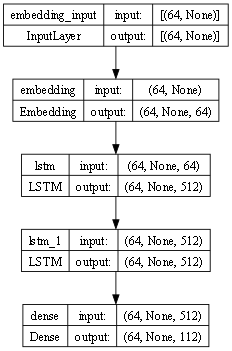

In [28]:
plot_model(rnn, 'images/rnn_model.png', show_shapes=True, dpi=BATCH_SIZE)

In [29]:
for vector_single, target_single in data.take(1):
    vector_single_pred = rnn(vector_single)
    ids = tf.random.categorical(vector_single_pred[0], num_samples=1)
    
    print('Размерность целевой последовательности:', target_single.numpy().shape)
    print('Размерность предсказанной последовательности:', vector_single_pred.shape)
    print('Размерность тензора с 1 индексом классов', ids.shape)
    print('Индекс класса:', ids[0][-1].numpy())

Размерность целевой последовательности: (64, 99)
Размерность предсказанной последовательности: (64, 99, 112)
Размерность тензора с 1 индексом классов (99, 1)
Индекс класса: 22


In [30]:
if os.path.isdir('checkpoints/') == False:
    os.mkdir('checkpoints/')

In [31]:
path_checkpoints = 'checkpoints/rnn/'

In [32]:
if os.path.isdir(path_checkpoints) == False:
    os.mkdir(path_checkpoints)

In [33]:
checkpoint_path = os.path.join(path_checkpoints, 'checkpoint_{epoch}')
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True)

In [34]:
rnn.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [35]:
history = rnn.fit(
    data, 
    epochs=15, 
    steps_per_epoch=BATCHES_PER_EPOCH, 
    callbacks=[checkpoint_callback]
)

Epoch 1/15
563/563 [==============================] - 1443s 3s/step - loss: 2.6580
Epoch 2/15
563/563 [==============================] - 1447s 3s/step - loss: 1.7998
Epoch 3/15
563/563 [==============================] - 1249s 2s/step - loss: 1.5051
Epoch 4/15
563/563 [==============================] - 1219s 2s/step - loss: 1.3942
Epoch 5/15
563/563 [==============================] - 1250s 2s/step - loss: 1.3309
Epoch 6/15
563/563 [==============================] - 1262s 2s/step - loss: 1.2869
Epoch 7/15
563/563 [==============================] - 1244s 2s/step - loss: 1.2529
Epoch 8/15
563/563 [==============================] - 1261s 2s/step - loss: 1.2245
Epoch 9/15
563/563 [==============================] - 1256s 2s/step - loss: 1.2000
Epoch 10/15
563/563 [==============================] - 1254s 2s/step - loss: 1.1785
Epoch 11/15
563/563 [==============================] - 1266s 2s/step - loss: 1.1596
Epoch 12/15
563/563 [==============================] - 1276s 2s/step - loss: 1.1429
E

In [42]:
def plot_performance(history: keras.callbacks.History,
                     n_epochs: int,
                     title: str) -> None:
    
    font_s = 12
    plt.figure(figsize=(6,5))
    
    plt.plot(history.history['loss'], '+-r')
    
    plt.title(f'{title}\n', size=font_s+4)
    
    plt.xlabel('Epoch', size=font_s,)
    plt.ylabel('Loss', size=font_s)
    
    plt.xticks(range(n_epochs))
    plt.grid()
    plt.show()

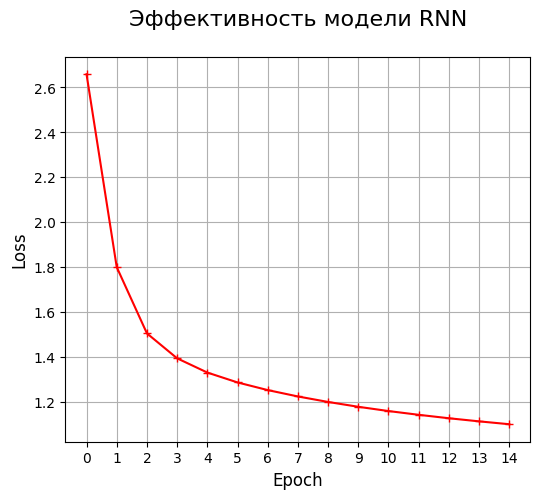

In [43]:
plot_performance(history, 15, 'Эффективность модели RNN')

In [38]:
rnn.reset_states()

In [39]:
def train_model(model: keras.Sequential,
                sample: str,
                n_characters: int,
                temperature: float,
                vocabulary: dict = vocabulary,
                batch_size: int = BATCH_SIZE) -> str:
    
    sample_vector = [tokenizer[s] for s in sample]
    predicted = sample_vector
    
    sample_tensor = tf.expand_dims(sample_vector, 0)
    sample_tensor = tf.repeat(sample_tensor, batch_size, axis=0)

    for i in range(n_characters):
        pred = model(sample_tensor)
        
        pred = pred[0].numpy() / temperature
        pred = tf.random.categorical(pred, num_samples=1)[-1, 0].numpy()
        
        predicted.append(pred)
        
        sample_tensor = predicted[-99:]
        sample_tensor = tf.expand_dims([pred], 0)
        
        sample_tensor = tf.repeat(sample_tensor, batch_size, axis=0)
        
    pred_characters = [vocabulary[i] for i in predicted]
    generated = ''.join(pred_characters)
    
    return generated

In [40]:
train_model(
    model=rnn,
    sample='гарри', 
    n_characters=1000, 
    temperature=0.6
)

Training process:   0%|          | 0/1000 [00:00<?, ?it/s]

'гарри призвал профессор макгонагалл, гарри поттер прислал свою палочку и осмотрел руки. — я понял, что ты спасёшь в своём курсе. — вингарри, когда люди гарри начнут смеяться, и дамблдор не хочет и дальше, создавая ловушки. метла с крестража и сразу же быстрее перед ним. на кладбище выкрикнули. — я должен был справиться с ней. — я обещал бы вызвать в куче все кого-то скоро волдеморта, который почувствовал, как сказал гарри. — ответьте ловушку. — как и это смертельное сообщение. с нао подойдут, а посково на кого он сам размером профессору квирреллу и и потому он сейчас умереть. на этот раз я не руковончено, когда он не мог получить эту тему, будьте войны я были не так говорить. — я согласен, что в сущности, с точки зрения моей магии, не успели просто «давление от которого все она могла отдать свои сына из них никогда не успела рассказать такую профессору снейпом и смотрела на гарри, и гарри не мог просто сдать резыны гермиона грейнджер. мальчику за последние детальную большой свет и раз

In [41]:
train_model(
    model=rnn,
    sample='гарри', 
    n_characters=1000, 
    temperature=0.8
)

Training process:   0%|          | 0/1000 [00:00<?, ?it/s]

'гарри поттер, что ты далеко в других идеи, которое я серьёзно. ти спасло от дементоров, мистер поттер, — сказал гарри. погрузившись, ретешь лишь возразила, что ты наверняка она умерла. — в голове мила, в мотрей фигуры открылась, он оставил между авроров, а потом освещал северус. — тень любопытное? — я не осознал, что, если волдеморт проснулся к выводу. — эм-м, я получивающих сигнал. теперь я был рассказывать своего лучами по какой-то прекрасной силы. — в конце концов у меня придётся улучшить эту некарснику, может быть не менее полетельник или успокоиться для него. пребывание оказались на мёртвых или словами. поэтому я существует. полезным голосом просто можно было бы взять за свои руки, чтобы я хотите возьма жизни, с любой ценой, вероятно, и твои отказанные на плоках ни одна из делом для профессора квиррелла. если вы ему думали, что тёмный лорд смог приходить с собой гарри, что если он прав, что представляете, какой бы то ни с пять монотонного гарри со всей этих сложных учеников со см

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 4 Общий вывод

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>